<a href="https://colab.research.google.com/github/manabil/Tensorflow-Advanced-Techniques-Specialization/blob/main/Custom%20and%20Distributed%20Training%20with%20Tensorflow/Week%204/C2_W4_Lab_3_using_TPU_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPU Strategy

In this ungraded lab you'll learn to set up the TPU Strategy. It is recommended you run this notebook in Colab by clicking the badge above. This will give you access to a TPU as mentioned in the walkthrough video. Make sure you set your `runtime` to `TPU.`

## Imports

In [1]:
import os
import random
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer
print("TensorFlow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version 2.12.0


## Set up TPUs and initialize TPU Strategy

Ensure to change the runtime type to TPU in Runtime -> Change runtime type -> TPU

In [2]:
# Detect hardware
TPUResolver = tf.distribute.cluster_resolver.TPUClusterResolver
try:
    tpu_address: str = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    # TPU detection
    tpu: TPUResolver = tf.distribute.cluster_resolver.TPUClusterResolver(
        tpu_address
    )
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy: tf.distribute.Strategy = tf.distribute.TPUStrategy(tpu)
    # Going back and forth between TPU and host is expensive.
    # Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    print("Number of accelerators: ", strategy.num_replicas_in_sync)
except ValueError:
    print('TPU failed to initialize.')

Running on TPU  ['10.53.16.226:8470']
Number of accelerators:  8


## Download the Data from Google Cloud Storage


In [3]:
SIZE: int = 224 #@param ["192", "224", "331", "512"] {type:"raw"}
IMAGE_SIZE: list[int] = [SIZE, SIZE]

In [4]:
GCS_PATTERN: str = f'gs://flowers-public/tfrecords-jpeg-{SIZE}x{SIZE}/*.tfrec'

# On TPU in Keras, this is the per-core batch size. The global batch size is
# 8x this.
BATCH_SIZE: int = 128

VALIDATION_SPLIT: float = 0.2
# do not change, maps to the labels in the data (folder names)
CLASSES: list[str] = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# splitting data files between training and validation
filenames: list = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)

split: int = int(len(filenames) * VALIDATION_SPLIT)
training_filenames: list = filenames[split:]
validation_filenames: list = filenames[:split]
print(f"Pattern matches {len(filenames)} data files. ", end="")
print(f"Splitting dataset into {len(training_filenames)} training ", end="")
print(f"files and {len(validation_filenames)} validation files")

validation_size: int = int((3670//len(filenames)) * len(validation_filenames))
training_size: int = int((3670//len(filenames)) * len(training_filenames))
validation_steps: int = validation_size // BATCH_SIZE
steps_per_epoch: int = training_size // BATCH_SIZE
print(f"With a batch size of {BATCH_SIZE}, there will be ", end="")
print(f"{steps_per_epoch} batches per training epoch and ", end="")
print(f"{validation_steps} batch(es) per validation run.")

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


## Create a dataset from the files

- load_dataset takes the filenames and turns them into a tf.data.Dataset
- read_tfrecord parses out a tf record into the image, class and a one-hot-encoded version of the class
- Batch the data into training and validation sets with helper functions


In [5]:
def read_tfrecord(example: tf.Tensor) -> tuple[tf.Tensor, ...]:
    features: dict[str, object] = {
        # tf.string means bytestring
        "image": tf.io.FixedLenFeature([], tf.string),
        # shape [] means scalar
        "class": tf.io.FixedLenFeature([], tf.int64),
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example: dict[str, tf.Tensor] = tf.io.parse_single_example(
        example, features
    )
    image: tf.Tensor = example['image']
    class_label: tf.Tensor = example['class']
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    # convert image to floats in [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0
    class_label = tf.cast(class_label, tf.int32)
    return image, class_label

def load_dataset(filenames: list) -> tf.data.Dataset:
    # read from TFRecords. For optimal performance, use
    # "interleave(tf.data.TFRecordDataset, ...)"
    # to read from multiple TFRecord files at once and set the option
    # experimental_deterministic = False to allow order-altering optimizations.

    option_no_order: tf.data.Options = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.with_options(option_no_order)
    # faster
    dataset = dataset.interleave(
        tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO
    )
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_batched_dataset(filenames: list) -> tf.data.Dataset:
    dataset: tf.data.Dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    # drop_remainder will be needed on TPU
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_training_dataset() -> tf.distribute.DistributedDataset:
    dataset: tf.data.Dataset = get_batched_dataset(training_filenames)
    dataset = strategy.experimental_distribute_dataset(dataset)
    return dataset

def get_validation_dataset() -> tf.distribute.DistributedDataset:
    dataset: tf.data.Dataset = get_batched_dataset(validation_filenames)
    dataset = strategy.experimental_distribute_dataset(dataset)
    return dataset

## Define the Model and training parameters

In [6]:
class MyModel(tf.keras.Model):
    def __init__(self, classes) -> None:
        super(MyModel, self).__init__()
        self._conv1a: Layer = tf.keras.layers.Conv2D(
            kernel_size=3, filters=16, padding='same', activation='relu'
        )
        self._conv1b: Layer = tf.keras.layers.Conv2D(
            kernel_size=3, filters=30, padding='same', activation='relu'
        )
        self._maxpool1: Layer = tf.keras.layers.MaxPooling2D(pool_size=2)

        self._conv2a: Layer = tf.keras.layers.Conv2D(
            kernel_size=3, filters=60, padding='same', activation='relu'
        )
        self._maxpool2: Layer = tf.keras.layers.MaxPooling2D(pool_size=2)

        self._conv3a: Layer = tf.keras.layers.Conv2D(
            kernel_size=3, filters=90, padding='same', activation='relu'
        )
        self._maxpool3: Layer = tf.keras.layers.MaxPooling2D(pool_size=2)

        self._conv4a: Layer = tf.keras.layers.Conv2D(
            kernel_size=3, filters=110, padding='same', activation='relu'
        )
        self._maxpool4: Layer = tf.keras.layers.MaxPooling2D(pool_size=2)

        self._conv5a: Layer = tf.keras.layers.Conv2D(
            kernel_size=3, filters=130, padding='same', activation='relu'
        )
        self._conv5b: Layer = tf.keras.layers.Conv2D(
            kernel_size=3, filters=40, padding='same', activation='relu'
        )

        self._pooling: Layer = tf.keras.layers.GlobalAveragePooling2D()
        self._classifier: Layer = tf.keras.layers.Dense(
            classes, activation='softmax'
        )

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        x: tf.Tensor = self._conv1a(inputs)
        x = self._conv1b(x)
        x = self._maxpool1(x)

        x = self._conv2a(x)
        x = self._maxpool2(x)

        x = self._conv3a(x)
        x = self._maxpool3(x)

        x = self._conv4a(x)
        x = self._maxpool4(x)

        x = self._conv5a(x)
        x = self._conv5b(x)

        x = self._pooling(x)
        x = self._classifier(x)
        return x

In [7]:
with strategy.scope():
    model: MyModel = MyModel(classes=len(CLASSES))
    # Set reduction to `none` so we can do the reduction afterwards and divide
    # by global batch size.
    Losses = tf.keras.losses.Loss
    loss_object: Losses = tf.keras.losses.SparseCategoricalCrossentropy(
        reduction=tf.keras.losses.Reduction.NONE
    )

    def compute_loss(labels: tf.Tensor, predictions: tf.Tensor) -> tf.Tensor:
        per_example_loss: tf.Tensor = loss_object(labels, predictions)
        global_batch_size: int = BATCH_SIZE * strategy.num_replicas_in_sync
        return tf.nn.compute_average_loss(
            per_example_loss, global_batch_size=global_batch_size
        )

    Metrics = tf.keras.metrics.Metric
    test_loss: Metrics = tf.keras.metrics.Mean(name='test_loss')

    train_accuracy: Metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        name='train_accuracy'
    )
    test_accuracy: Metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        name='test_accuracy'
    )

    optimizer: tf.keras.optimizers.Optimizer = tf.keras.optimizers.Adam()

    @tf.function
    def distributed_train_step(
        dataset_inputs: tf.distribute.DistributedDataset
    ) -> tf.Tensor:
        per_replica_losses: tf.Tensor = strategy.run(
            train_step,args=(dataset_inputs,)
        )
        # print(per_replica_losses)
        return strategy.reduce(
            tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None
        )

    @tf.function
    def distributed_test_step(
        dataset_inputs: tf.distribute.DistributedDataset
    ) -> None:
        strategy.run(test_step, args=(dataset_inputs,))


    def train_step(inputs: tf.distribute.DistributedDataset) -> tf.Tensor:
        images: tf.Tensor
        labels: tf.Tensor
        images, labels = inputs

        with tf.GradientTape() as tape:
            predictions: tf.Tensor = model(images)
            loss: tf.Tensor = compute_loss(labels, predictions)

        gradients: list = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_accuracy.update_state(labels, predictions)

        return loss

    def test_step(inputs: tf.distribute.DistributedDataset) -> None:
        images: tf.Tensor
        labels: tf.Tensor
        images, labels = inputs

        predictions: tf.Tensor = model(images)
        loss: tf.Tensor = loss_object(labels, predictions)

        test_loss.update_state(loss)
        test_accuracy.update_state(labels, predictions)


In [8]:
EPOCHS: int = 40
with strategy.scope():
    for epoch in range(EPOCHS):
        # TRAINING LOOP
        total_loss: float = 0.0
        num_batches: int = 0
        for x in get_training_dataset():
            total_loss += distributed_train_step(x)
            num_batches += 1
        train_loss: float = total_loss / num_batches

        # TESTING LOOP
        for x in get_validation_dataset():
            distributed_test_step(x)

        print(f"Epoch {epoch+1}, Loss: {train_loss}, ", end="")
        print(f"Accuracy: {train_accuracy.result()*100}, ", end="")
        print(
            f"Test Loss: {test_loss.result()/strategy.num_replicas_in_sync}, ",
            end=""
        )
        print(f"Test Accuracy: {test_accuracy.result()*100}")

        test_loss.reset_states()
        train_accuracy.reset_states()
        test_accuracy.reset_states()

Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 1, Loss: 0.1865932196378708, Accuracy: 26.30872344970703, Test Loss: 0.17462313175201416, Test Accuracy: 35.94203186035156


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 2, Loss: 0.15742887556552887, Accuracy: 43.02013397216797, Test Loss: 0.15841616690158844, Test Accuracy: 37.826087951660156


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 3, Loss: 0.14418330788612366, Accuracy: 47.013423919677734, Test Loss: 0.1430339813232422, Test Accuracy: 49.565216064453125


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 4, Loss: 0.13481810688972473, Accuracy: 52.14765167236328, Test Loss: 0.13660797476768494, Test Accuracy: 52.89855194091797


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 5, Loss: 0.1285339742898941, Accuracy: 55.6375846862793, Test Loss: 0.13782232999801636, Test Accuracy: 57.10144805908203


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 6, Loss: 0.12505801022052765, Accuracy: 57.51677703857422, Test Loss: 0.13347718119621277, Test Accuracy: 54.0579719543457


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 7, Loss: 0.11825856566429138, Accuracy: 60.73825454711914, Test Loss: 0.1348547637462616, Test Accuracy: 55.21739196777344


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 8, Loss: 0.1141187846660614, Accuracy: 63.69127655029297, Test Loss: 0.11953630298376083, Test Accuracy: 62.89855194091797


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 9, Loss: 0.11005000025033951, Accuracy: 63.489933013916016, Test Loss: 0.1165759339928627, Test Accuracy: 63.623191833496094


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 10, Loss: 0.10806885361671448, Accuracy: 63.59060287475586, Test Loss: 0.1182701587677002, Test Accuracy: 60.000003814697266


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 11, Loss: 0.10439752787351608, Accuracy: 66.24160766601562, Test Loss: 0.11734195798635483, Test Accuracy: 66.9565200805664


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 12, Loss: 0.10018438845872879, Accuracy: 68.08724975585938, Test Loss: 0.10922544449567795, Test Accuracy: 68.40579223632812


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 13, Loss: 0.09656887501478195, Accuracy: 69.328857421875, Test Loss: 0.1071663647890091, Test Accuracy: 65.94203186035156


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 14, Loss: 0.09352090209722519, Accuracy: 70.13423156738281, Test Loss: 0.111800916492939, Test Accuracy: 67.82608795166016


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 15, Loss: 0.09815919399261475, Accuracy: 69.12751770019531, Test Loss: 0.10106917470693588, Test Accuracy: 69.13043212890625


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 16, Loss: 0.09221551567316055, Accuracy: 70.83892822265625, Test Loss: 0.1005738377571106, Test Accuracy: 69.4202880859375


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 17, Loss: 0.09047922492027283, Accuracy: 72.28187561035156, Test Loss: 0.09583702683448792, Test Accuracy: 70.28985595703125


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 18, Loss: 0.08590725809335709, Accuracy: 73.12080383300781, Test Loss: 0.09330630302429199, Test Accuracy: 73.0434799194336


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 19, Loss: 0.08157586306333542, Accuracy: 74.19462585449219, Test Loss: 0.09239861369132996, Test Accuracy: 71.59420013427734


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 20, Loss: 0.08090317249298096, Accuracy: 75.57047271728516, Test Loss: 0.0946211889386177, Test Accuracy: 71.73912811279297


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 21, Loss: 0.0830199122428894, Accuracy: 74.09396362304688, Test Loss: 0.09253518283367157, Test Accuracy: 71.159423828125


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 22, Loss: 0.07877985388040543, Accuracy: 74.96644592285156, Test Loss: 0.09484577178955078, Test Accuracy: 72.60869598388672


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 23, Loss: 0.07652914524078369, Accuracy: 76.17449951171875, Test Loss: 0.08827853947877884, Test Accuracy: 72.60869598388672


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 24, Loss: 0.07382715493440628, Accuracy: 76.71141052246094, Test Loss: 0.08125399053096771, Test Accuracy: 76.23188781738281


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 25, Loss: 0.07082966715097427, Accuracy: 78.5905990600586, Test Loss: 0.09962306171655655, Test Accuracy: 70.14492797851562


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 26, Loss: 0.07398226112127304, Accuracy: 76.57717895507812, Test Loss: 0.08239339292049408, Test Accuracy: 76.37681579589844


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 27, Loss: 0.06711969524621964, Accuracy: 78.92617797851562, Test Loss: 0.08088112622499466, Test Accuracy: 76.66666412353516


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 28, Loss: 0.06499182432889938, Accuracy: 80.2684555053711, Test Loss: 0.0877423956990242, Test Accuracy: 74.78260803222656


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 29, Loss: 0.06245683506131172, Accuracy: 80.2684555053711, Test Loss: 0.08033189922571182, Test Accuracy: 78.55072784423828


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 30, Loss: 0.06331386417150497, Accuracy: 81.20805358886719, Test Loss: 0.07998313009738922, Test Accuracy: 76.23188781738281


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 31, Loss: 0.062277715653181076, Accuracy: 80.30200958251953, Test Loss: 0.08900564163923264, Test Accuracy: 73.76811218261719


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 32, Loss: 0.056584253907203674, Accuracy: 83.28858947753906, Test Loss: 0.0855117067694664, Test Accuracy: 75.50724792480469


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 33, Loss: 0.05695900693535805, Accuracy: 82.11409759521484, Test Loss: 0.08135583996772766, Test Accuracy: 76.81159210205078


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 34, Loss: 0.05493694916367531, Accuracy: 83.0536880493164, Test Loss: 0.07850416004657745, Test Accuracy: 78.26087188720703


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 35, Loss: 0.047509849071502686, Accuracy: 85.20133972167969, Test Loss: 0.0763310119509697, Test Accuracy: 79.71014404296875


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 36, Loss: 0.04812471568584442, Accuracy: 85.57047271728516, Test Loss: 0.08800218254327774, Test Accuracy: 74.92753601074219


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 37, Loss: 0.0550956130027771, Accuracy: 83.92617797851562, Test Loss: 0.09572551399469376, Test Accuracy: 72.89855194091797


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 38, Loss: 0.05379125848412514, Accuracy: 83.32215118408203, Test Loss: 0.08216854929924011, Test Accuracy: 76.81159210205078


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 39, Loss: 0.050472140312194824, Accuracy: 84.19463348388672, Test Loss: 0.09649640321731567, Test Accuracy: 73.91304016113281


Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b9a080b8160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 40, Loss: 0.04624048247933388, Accuracy: 86.40939331054688, Test Loss: 0.08448030799627304, Test Accuracy: 77.97101593017578


## Predictions

In [9]:
#@title display utilities [RUN ME]
def dataset_to_numpy_util(dataset: tf.data.Dataset, N: int) -> tuple:
    dataset = dataset.batch(N)

    if tf.executing_eagerly():
        # In eager mode, iterate in the Datset directly.
        for images, labels in dataset:
            numpy_images: np.ndarray = images.numpy()
            numpy_labels: np.ndarray = labels.numpy()
            break
    # In non-eager mode, must get the TF note that yields the nextitem and run
    # it in a tf.Session.
    else:
        Iterator = tf.data.Iterator
        get_next_item: Iterator = dataset.make_one_shot_iterator().get_next()
        with tf.Session() as ses:
            numpy_images, numpy_labels = ses.run(get_next_item)

    return numpy_images, numpy_labels

def title_from_label_and_target(
    label, correct_label: np.ndarray
) -> tuple[str, bool]:
    # one-hot to class number
    label: np.int64 = np.argmax(label, axis=-1)
    # correct_label = np.argmax(correct_label, axis=-1) # one-hot to class
    # number
    correct: bool = (label == correct_label)
    correct_class: str = ""
    if not correct:
        correct_class += f", should be {CLASSES[correct_label]}"
    info: str = f"{CLASSES[label]} [{correct}{correct_class}]"
    return info, correct

def display_one_flower(
    image: np.ndarray, title: str, subplot: int, red: bool=False
) -> int:
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot + 1

def display_9_images_with_predictions(
    images: np.ndarray, predictions: tf.Tensor, labels: np.ndarray
) -> None:
    subplot: int = 331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title: str
        correct: bool
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower(image, title, subplot, not correct)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [10]:
inference_model: MyModel = model

In [11]:
some_flowers, some_labels = dataset_to_numpy_util(
    load_dataset(validation_filenames), 8*20
)

['sunflowers', 'daisy', 'dandelion', 'dandelion', 'roses', 'dandelion', 'dandelion', 'roses', 'tulips', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'roses', 'tulips', 'dandelion', 'tulips', 'tulips', 'tulips', 'dandelion', 'roses', 'roses', 'dandelion', 'roses', 'dandelion', 'tulips', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'tulips', 'roses', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'roses', 'roses', 'roses', 'dandelion', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'daisy', 'daisy', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'roses', 'roses', 'roses', 'roses', 'tulips', 'daisy', 'tulips', 'tulips', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'tulips', 'roses', 'daisy

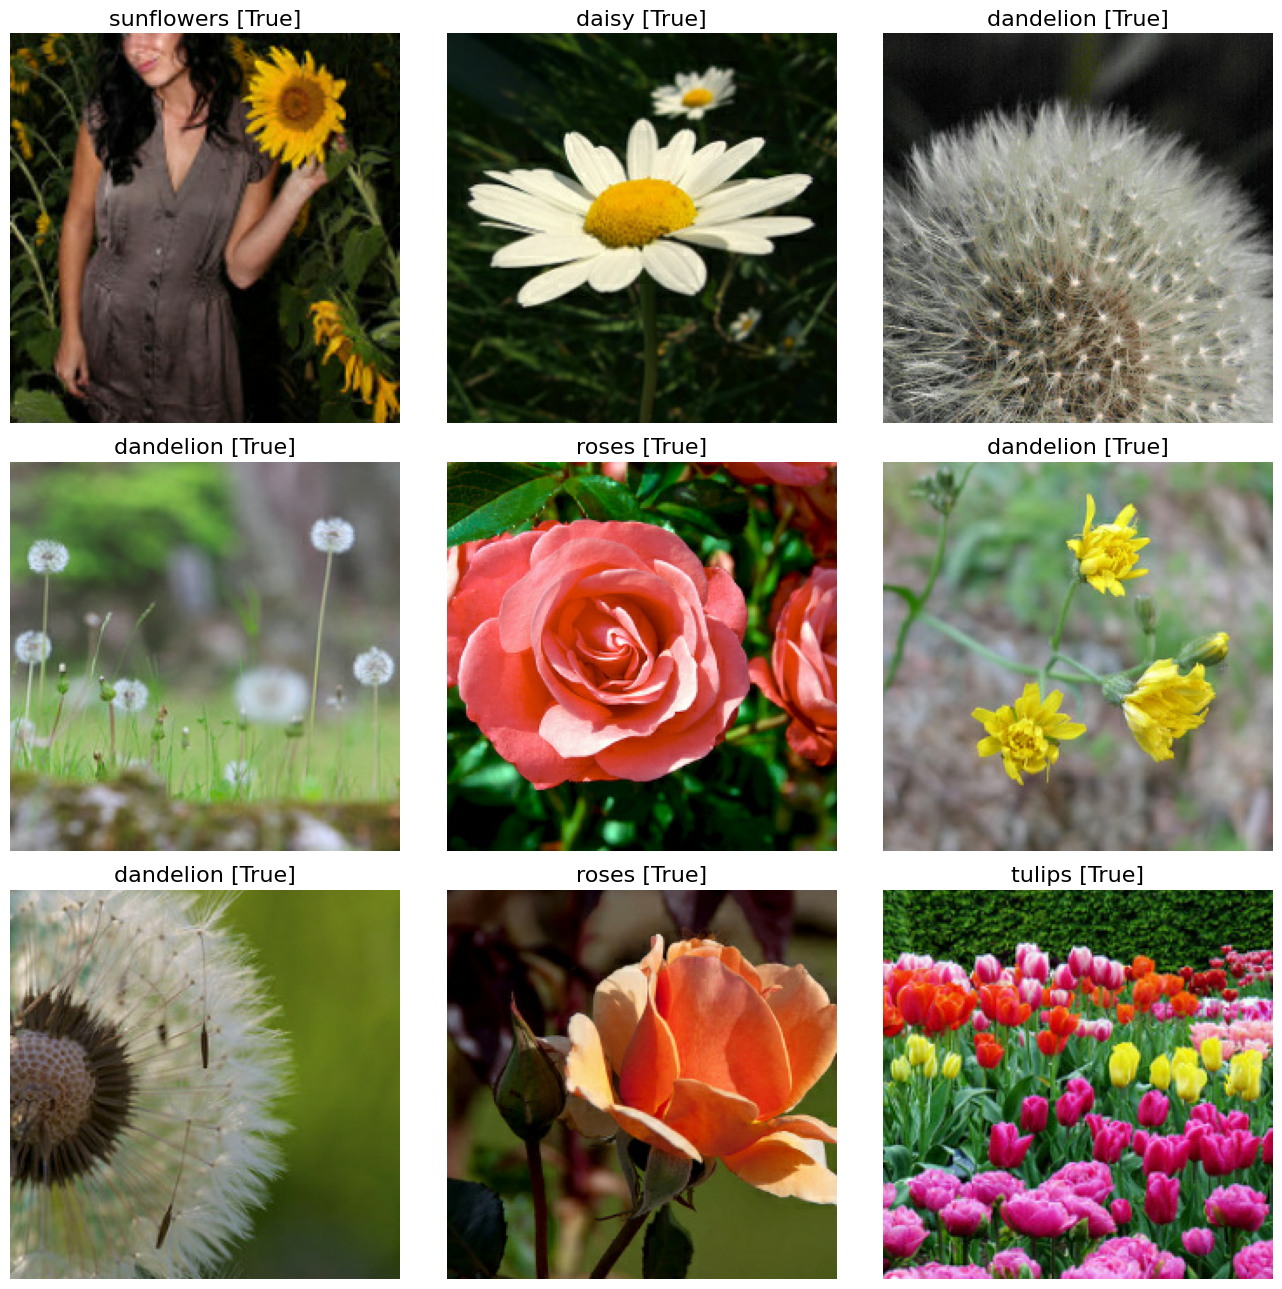

In [12]:
# randomize the input so that you can execute multiple times to change results
permutation: np.ndarray = np.random.permutation(8*20)
some_flowers: np.ndarray = some_flowers[permutation]
some_labels: np.ndarray = some_labels[permutation]

predictions: tf.Tensor = inference_model(some_flowers)

print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

display_9_images_with_predictions(some_flowers, predictions, some_labels)